# Part 3
# Get the embedding for the title of the papers

In this section we will perform a common techique in NLP which consist in transform the text to a set of vectors each one representing a word inside a document. *Our goal is to* ***transform the title of the papers into its embedding version***.<br>
At the end of the pre-processing the document will be transformed into a list of vectors or a matrix of $n \times  m$ where $n$ is the number of words in the document and $m$ is the size of the vector that represents the word $n$.

In order to perform the embedding, a pre-trained model was used that is available in the followin link:
https://dl.fbaipublicfiles.com/fasttext/vectorswiki/wiki.en.vec

that consist of a set of pre-trained word vectors for 294 languages, trained on Wikipedia using *FastText*.<br> These vectors in dimension 300 were obtained using the skip-gram model described in Bojanowski et al. (2016) with default parameters.


In [1]:
# Import packages
import io
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

import dask
from dask.distributed import Client, SSHCluster, progress
from dask import delayed
import dask.bag as db
import paramiko
import distributed

import matplotlib.pyplot as plt
import seaborn as sns

import os
import json
import numpy as np
import pandas as pd
import time
import warnings
warnings.filterwarnings("ignore")

In order to load the vectors we made use of the *gensim.models.KeyedVectors* which is a module that implements word vectors and their similarity look-ups. Each entity is identified by its string id, so this is a mapping between <br>{*str* $\rightarrow$ 1D numpy array}.

(https://radimrehurek.com/gensim/models/keyedvectors.html)

In [2]:
%%time

#load the embedded words from pre-trained model
model = KeyedVectors.load_word2vec_format('./data/wiki.en.vec')
#model = KeyedVectors.load_word2vec_format('./data/wiki-news-300d-1M.vec')

CPU times: user 5min 36s, sys: 8.68 s, total: 5min 44s
Wall time: 5min 43s


In [3]:
#Not used becouse kernel die

#def load_vectors(fname):
#    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
#    n, d = map(int, fin.readline().split())
#    data = {}
#    for line in fin:
#        tokens = line.rstrip().split(' ')
#        data[tokens[0]] = map(float, tokens[1:])
#    return data

In [4]:
#%%time 
#model = load_vectors('./data/wiki-news-300d-1M.vec')
#model['hello']

In [3]:
#to get the embedding of word ’hello’
model['hello']

array([-1.920e-01,  1.544e-01,  4.670e-02,  5.920e-02,  1.369e-01,
       -7.720e-02, -3.840e-02,  5.370e-02,  1.435e-01, -1.353e-01,
       -5.300e-02, -6.680e-02,  1.850e-02,  8.730e-02,  9.030e-02,
        1.663e-01,  3.500e-03, -2.102e-01,  2.010e-01, -2.490e-02,
       -2.790e-02, -3.241e-01, -6.600e-03, -2.640e-02, -1.628e-01,
       -1.094e-01, -8.820e-02,  9.700e-03,  1.228e-01,  5.900e-03,
       -5.100e-02,  6.490e-02,  1.577e-01,  1.740e-02,  9.910e-02,
        1.328e-01, -5.860e-02,  1.814e-01, -9.800e-03,  1.877e-01,
        5.180e-02, -6.970e-02, -6.290e-02, -1.981e-01, -1.373e-01,
       -8.110e-02, -6.310e-02, -6.390e-02,  1.244e-01, -2.470e-02,
        2.250e-02, -3.174e-01, -8.462e-01, -1.248e-01,  8.240e-02,
        2.120e-02,  9.960e-02, -3.440e-02,  1.383e-01, -9.830e-02,
        1.637e-01, -1.906e-01, -1.969e-01,  1.473e-01,  1.318e-01,
       -7.000e-02,  3.040e-02, -3.450e-02,  1.507e-01, -1.786e-01,
        1.038e-01, -3.500e-03, -9.300e-02,  1.255e-01,  1.431e

In [4]:
def Cluster( nprocs, nthreads=1,memory_limit="2GB", n_core_VM=4): #number_nodes=3,
    
    scheduler = "10.67.22.84"
    nodes = ["10.67.22.84", "10.67.22.254", "10.67.22.111"]
    
    if nprocs <= n_core_VM: 
        string = ("-"+ nodes[2]) *(nprocs)
        workers = string[1:].split("-")
    elif nprocs <= 2*n_core_VM:
        string = ("-"+ nodes[2])*(n_core_VM) + ("-"+ nodes[1])*(nprocs-n_core_VM)
        workers = string[1:].split("-")
    elif nprocs <= 3*n_core_VM:
        string = ("-"+ nodes[2])*(n_core_VM) +("-"+ nodes[1])*(n_core_VM) +("-"+ nodes[0])*(nprocs-2*n_core_VM)
        workers = string[1:].split("-")
    else:
        print("Warning: Too much cores selected ---> Set all cores available.")
        string = ("-"+ nodes[2])*(n_core_VM) +("-"+ nodes[1])*(n_core_VM) +("-"+ nodes[0])*(nprocs-2*n_core_VM)
        workers = string[1:].split("-")
        
    workers.insert( 0 , scheduler )   
    
    memory = [c for c in memory_limit]
    
    c = SSHCluster( workers,
            connect_options={"known_hosts": None},
            worker_options={"nthreads" : nthreads, "memory_limit":memory_limit},
            scheduler_options={"port": 8786, "dashboard_address": 8787 })  
    
    return c

def dask_close_all():
    client.close()
    client.shutdown()
    !kill $(ps aux | grep '[d]istributed.cli.dask' | awk '{print $2}')
    !sh data/clusters_script/close_dask.sh


In [8]:
cluster = Cluster (nprocs=8, nthreads=1)
client = Client(cluster)
client

distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:33821'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.111:46181'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:42976'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nan

Client Scheduler: tcp://10.67.22.84:8786 Dashboard: http://10.67.22.84:8787/status,Cluster Workers: 12 Cores: 12 Memory: 15.83 GiB


We loaded all the papers as in the previous ***Part 1*** and ***Part 2*** by creating a *Dask Bag*.

We built the function `flatten` which will return the ***paper_id*** and ***title*** fields of all the papers in order to be used with the *map* function provided by Dask Bag.
We also apply a filter in order to remove all the empty *title* fields.

In [9]:
b = db.read_text('data/1000papers_json_singleline/*.json').map(json.loads) # 1 partition for each json file
b

dask.bag<loads, npartitions=1000>

In [10]:
def flatten(record):
    return {
        "paper_id": record['paper_id'],
        "title": record['metadata']['title']
            }

In [11]:
 # removing the papers that don't have titles
data = b.map(flatten).filter(lambda record: bool(record['title'])).repartition(50).compute()
       

Now we make use of the pre-trained model and create two functions:

 - `create_dictionary(dict, model)`: which creates a dictionary consist of the "*paper_id*" and the embedding "*title*"
 
 
 - `title_embedder_func(text, wiki)`: which takes the text of the title as input,  convert all capital letters to small letters and split it. Then apply the pre-trained model and convert each word into an np.array().
 
It should be notice that lowering the text was necessary since the *'wiki.en.vec'* model is not able to detect Capital Letters. <br>

In [12]:
def create_dictionary(record, model):
    return { "paper_id": record["paper_id"],
             "title": record["title"],
             "title_emb": title_embedder_func(record['title'], model)
            }

In [13]:
def title_embedder_func(text, wiki):
    text_split = text.lower().split() # we lower case all the words of the title to get a proper cosine similarity
    words_embedded=[]
    
    for words in text_split:
        try:
            words_embedded.append( wiki[words])
        except:
            pass  #some of the words weren't on the model because they were to scientific.
   
    return words_embedded

In [14]:
titles_embedded = [create_dictionary( d,  model) for d in data]

Convert list to dask bag using *db.from_sequence*

In [15]:
%%time
titles = db.from_sequence(titles_embedded)

CPU times: user 24 s, sys: 30 ms, total: 24.1 s
Wall time: 24.1 s


In [16]:
titles.take(1)

({'paper_id': '0003ddc51c4291d742855e9ac56076a3bea33ad7',
  'title': 'Journal Pre-proofs The Fire This Time: The Stress of Racism, Inflammation and COVID-19',
  'title_emb': [array([-1.484e-01,  7.040e-02,  3.700e-02, -3.310e-02, -1.068e-01,
           9.860e-02,  1.010e-01, -3.980e-02, -1.409e-01,  2.130e-02,
          -1.660e-02,  5.370e-02, -7.670e-02, -4.310e-02, -2.080e-01,
          -2.540e-02,  1.263e-01,  7.910e-02, -9.620e-02, -1.560e-02,
          -1.988e-01, -1.841e-01,  6.800e-03,  2.720e-02,  1.570e-02,
          -7.340e-02,  9.600e-03, -7.230e-02,  9.600e-03,  4.840e-02,
           1.018e-01, -4.440e-02,  8.140e-02, -2.910e-02, -2.881e-01,
           8.310e-02, -5.190e-02, -1.710e-02,  8.660e-02,  1.098e-01,
          -1.841e-01, -1.230e-01, -1.749e-01, -5.290e-02, -2.110e-02,
          -3.710e-02, -1.220e-02,  8.680e-02, -3.940e-02,  2.485e-01,
          -9.490e-02,  1.181e-01, -6.269e-01,  8.800e-03, -1.874e-01,
          -2.215e-01,  2.110e-02,  4.040e-02, -5.200e-03, 

# 3.3.1 Bonus point

We will now make used of the previously generated vectors to compute the cosine similarity between each paper and to figure out a couple of papers with the highest cosine similarity score.

We first begin by defining the  `cosine_similarity ` function which basically computes the similarity between the texts ( https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa ).

We compute the similarity word by word among the texts. 
If one of the title has more words than the other, we compute the cosine similarity only for a number of words that correspond to the smaller title. 
When one of the text end, there's no more comparision. 

An example to understand the cosine similarity is shown in the image below.  

<img src="./data/image2.png" alt="Cosine similarity" style="height: 350px"/>


Also we defined a function `similarity `  that computes the similarity among two different sentence and return a dictionary.<br> Finally we construct a **similarity matrix**.

In [17]:
def cosine_similarity(vec1, vec2):

    norm_vec1 = np.linalg.norm(vec1)   # norm of 1st embedded title
    norm_vec2 =  np.linalg.norm(vec2)  # norm of 2st embedded title
    
    m = min(len(vec1), len(vec2)) # min of the length of either of two vectors is taken to compute inner product
    
    result = np.vdot(vec1[:m], vec2[:m])/(norm_vec1*norm_vec2) #compute the cosine similarity
    return result

In [18]:
def similarity(vec1, vec2):
    
    cos_sim = cosine_similarity(vec1['title_emb'], vec2['title_emb'])
    
    return{
        'paper 1': vec1['paper_id'],
        'paper 2' : vec2['paper_id'],
        'similarity' : cos_sim,
        'title 1': vec1['title'],
        'title 2' : vec2['title'],
    }

In [19]:
# Constructing a similarity matrix
dim = len(titles_embedded) # dimension of the matrix (papers that have title = 901)
sim_matrix = np.zeros((dim,dim))

for i in range(dim):
    for j in range(dim):
        vec_i = titles_embedded[i]
        vec_j = titles_embedded[j]
        sim_matrix[i][j] = similarity(vec_i,vec_j)['similarity']

Visualizing similarity matrix for all papers that have titles


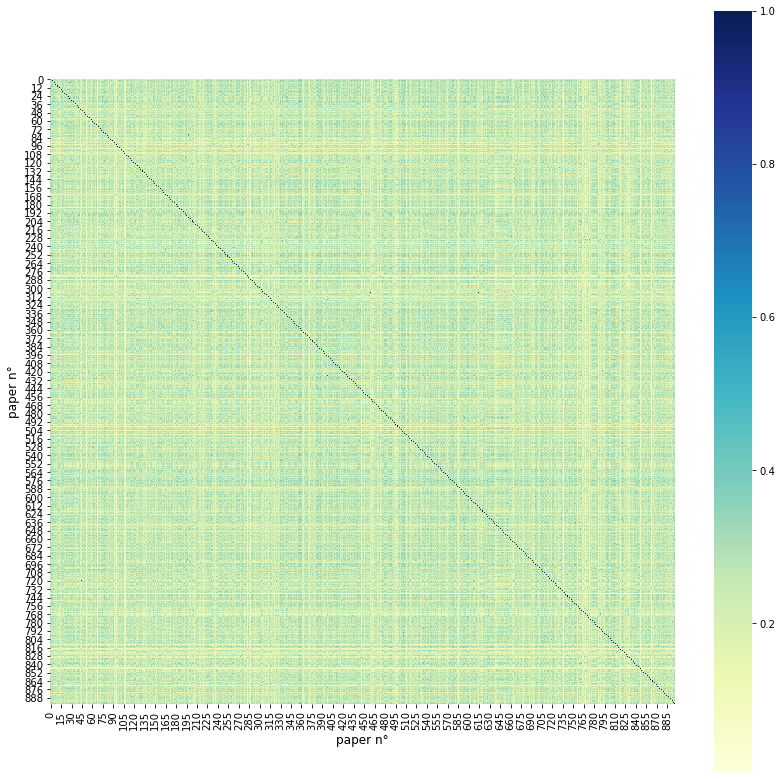

In [20]:
plt.figure(figsize=(14,14))

sns.heatmap( sim_matrix, square=True , cmap="YlGnBu")
#sns.heatmap(sim_matrix,cmap=sns.diverging_palette(20, 220, n=200), square=True)
plt.xlabel('paper n°', size = 12)
plt.ylabel('paper n°', size = 12)
plt.show()

Visualizing similarity for first 30 papers:

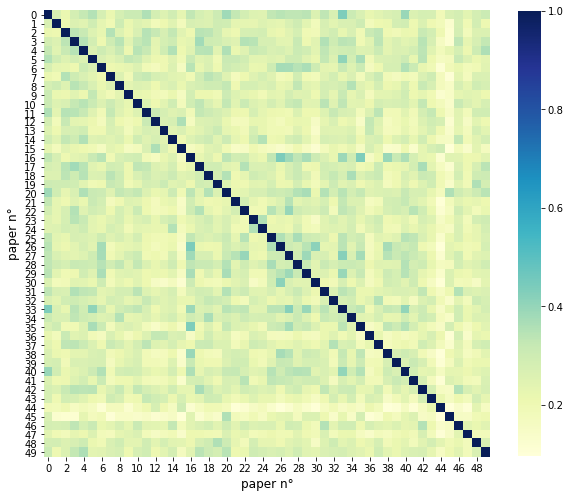

In [25]:
fig = plt.figure(figsize=(10,10))

sns.heatmap( sim_matrix[:50,:50], square=True, cmap="YlGnBu", cbar_kws={"shrink": .82})
#sns.heatmap(sim_matrix,cmap=sns.diverging_palette(20, 220, n=200), square=True)

plt.xlabel('paper n°', size = 12)
plt.ylabel('paper n°', size = 12)
plt.show()
fig.savefig("similarity.pdf", transparent = True,  bbox_inches = 'tight', pad_inches = 0)

We could notice how most papers have a value of the *cosine similarity* that is smaller to $0.4$.

## Timing Cosine Similarity metric

We create a *Dataframe* and compute the time

In [22]:
start = time.time()

sim = []
for i in range( len(titles_embedded)):
    for j in range( i+1, len(titles_embedded)):   # since it is simmetric, we compute only half                                            # has the same similarity) 
        
#        if j == i: #were are not considering the similiarity of the same paper
#            pass
        
        try:
            sim.append( similarity( titles_embedded[i], titles_embedded[j]) )
        except:
            pass

# Quantitatively checking which papers have common titles
df = pd.DataFrame(sim)

similar_papers = df.sort_values( 'similarity', ascending = False).dropna()
similar_papers = similar_papers.reset_index( drop=True) # reset the index of df from 0 onwards for easy analysis
#similar_papers

stop=time.time()
print("time:",(stop-start), 's')

time_np = (stop-start) # store the computation time for further comparison with dask bag


time: 16.976917266845703 s


In [23]:
similar_papers.iloc[:,:3].head()

,paper 1,paper 2,similarity
0,3dbaeaa37720d072548adc83c435f498c580eb01,3e1c189ceab9b9edfef3fbc7f1aec12602e188cf,1.000000
1,03e30be309930708e8e82c283c6490dd8186e32b,3e44febff058d92b69b03be9dd48174e2636cc6a,1.000000
2,3dbaeaa37720d072548adc83c435f498c580eb01,3de4d818e172c047a72904cad9e5fb040ac62b0e,1.000000
3,3de4d818e172c047a72904cad9e5fb040ac62b0e,3e1c189ceab9b9edfef3fbc7f1aec12602e188cf,1.000000
4,3dd30d6d9df455180f58955e74961f6189c15ae2,3ddb0ddfb963ad69fb799bdc933096904a3d9865,0.845603


Top 10 papers that have high cosine similarity

In [24]:
# Pandas querying: courtesy:https://stackoverflow.com/questions/36684013/extract-column-value-based-on-another-column-pandas-dataframe/36685531

total_data = pd.DataFrame.from_dict(data) # convert from dask bag to pandas Dataframe

for i in range(10):
    paperid_1 = similar_papers['paper 1'][i]
    #title1 = total_data.loc[ total_data['paper_id'] == similar_papers['paper 1'][i], "title" ].iloc[0]
    title1 = similar_papers['title 1'][i]
    
    paperid_2 = similar_papers['paper 2'][i]
    #title2 = total_data.loc[ total_data['paper_id'] == similar_papers['paper 2'][i], "title" ].iloc[0]
    title2 = similar_papers['title 2'][i]
    
    cossim_value = similar_papers['similarity'][i]

    #print("Paper 1: "+paperid_1 +" Title: " + title1)
    #print("Paper 2: "+paperid_2 +" Title: " + title2)
    print(" Title1: " + title1, "\n")
    print(" Title2: " + title2, "\n")
    print("\tCosine similarity:",cossim_value, "\n")
    print("-"*50 + "\n")

 Title1: PEER REVIEW HISTORY 

 Title2: PEER REVIEW HISTORY 

	Cosine similarity: 1.0 

--------------------------------------------------

 Title1: Epidemiology and Infection 

 Title2: Epidemiology and Infection 

	Cosine similarity: 1.0 

--------------------------------------------------

 Title1: PEER REVIEW HISTORY 

 Title2: PEER REVIEW HISTORY 

	Cosine similarity: 1.0 

--------------------------------------------------

 Title1: PEER REVIEW HISTORY 

 Title2: PEER REVIEW HISTORY 

	Cosine similarity: 1.0 

--------------------------------------------------

 Title1: To appear in: Public Health 

 Title2: To appear in: Public Health in Practice 

	Cosine similarity: 0.8456025123596191 

--------------------------------------------------

 Title1: R E V I E W A R T I C L E Deciphering the COVID-19 cytokine storm: Systematic review and meta-analysis 

 Title2: R E V I E W A R T I C L E COVID 19-Perspective of an Italian Center 

	Cosine similarity: 0.7920541167259216 

---------

### Comparison of the *Numpy* model against *Dask Bag* 

We will do the same thing as before but applying *Dask Bag*. In order to deal with this, we need to create a bag that contains the combination of the dataset.

In [25]:
def bag_similarity(record):
    
    val = cosine_similarity(record[0]['title_emb'], record[1]['title_emb'])
    return {
        "paper 1": record[0]['paper_id'],
        "paper 2": record[1]['paper_id'],
        "similarity": val,
        "title 1": record[0]['title'],
        "title 2": record[1]['paper_id']
            }

In [26]:
data = db.from_sequence([(titles_embedded[i], titles_embedded[j]) for i in range(10) for j in range(i+1,10)]).repartition(50).map(bag_similarity).compute()
df = pd.DataFrame(data)
similar_papers = df.sort_values('similarity', ascending = False)
similar_papers = similar_papers.dropna()
similar_papers = similar_papers.reset_index(drop=True) # reset the index from 0 onwards for easy analysis
similar_papers.iloc[:,:3].head()

,paper 1,paper 2,similarity
0,003e59e774c01718d72ab67fc3a1bfeb36dd2f9d,03d42631d39021e20ecd51846e4a6a3aed6c37d0,0.352157
1,0003ddc51c4291d742855e9ac56076a3bea33ad7,03d372b931fe803b7c75c4ea486e7e45280950bc,0.351422
2,03d05413ecb3b0ee5d1c5194187708621b93326a,03d2029e7e230c8b61d3c9367e24e9112acdfe42,0.348509
3,03d05413ecb3b0ee5d1c5194187708621b93326a,03d4656a5a3759b8763e2713376456abe24ba9df,0.343044
4,003e59e774c01718d72ab67fc3a1bfeb36dd2f9d,03d05413ecb3b0ee5d1c5194187708621b93326a,0.336550


We are facing the problem that it is not feasible to do it in this way. We are going to show that when the size of the combination increases it also does the time.

In [27]:
def bag_dimension(N):
    data = db.from_sequence([(titles_embedded[i], titles_embedded[j]) for i in range(N) for j in range(i+1,N)]).repartition(50).map(bag_similarity).compute()

In [28]:
ttime = []
for i in range(50):
    start=time.time()
    bag_dimension(i)
    stop=time.time()
    ttime.append((stop-start))

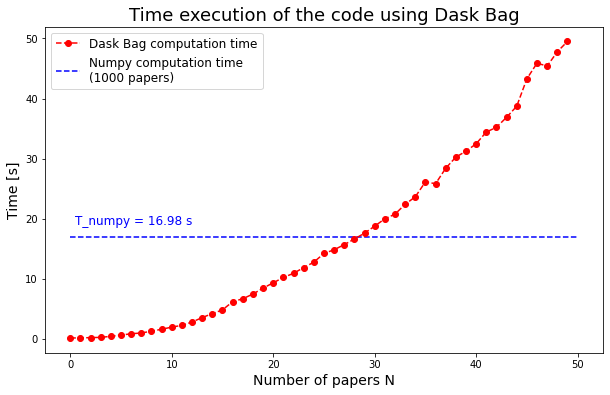

In [51]:
plt.figure(figsize=(10,6))
plt.plot(ttime,  linestyle='--', marker='o', color='r', label='Dask Bag computation time')
plt.title('Time execution of the code using Dask Bag',fontsize = 18)
plt.xlabel('Number of papers N', fontsize = 14)
plt.ylabel('Time [s]',fontsize = 14)
plt.text(0.5, 19, 'T_numpy = %0.2f s'%time_np ,c='blue' ,fontsize=12)
plt.hlines(time_np,0,50, color='blue', linestyles='--', label ='Numpy computation time \n(1000 papers)')
plt.legend( fontsize = 12)
plt.show()

As it can be seen from the above graph, running the code with numpy is much faster that creating the bag with all the combination of the papers (notice that in the graph we just consider at max 50 papers and we can already notice huge time difference, imagine the implementation time run through for all the papers!). It can be seen that it goes with $N^{2}$. Also, note that in the above graph, the execution time by using numpy is for all the combination of papers.

In [30]:
dask_close_all()